In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.models import ResNet50_Weights 
from torch.utils.data import DataLoader, random_split, Subset
from sklearn.metrics import classification_report, confusion_matrix
from torch.cuda.amp import GradScaler, autocast 
import numpy as np
import cv2
import os
import imutils 
from tqdm.notebook import tqdm
import time
import copy
import matplotlib.pyplot as plt

print("Libraries imported.")

Libraries imported.


In [ ]:

INPUT_TRAIN_DIR = './Training' 

OUTPUT_PREPROC_DIR = './Training_preproc'

# --- Hiperparametrii ---

IMG_SIZE = 224


NUM_CLASSES = 4       
BATCH_SIZE = 32
NUM_EPOCHS = 25      
LEARNING_RATE = 0.001
VAL_SPLIT = 0.2       

# --- Device Setup ---
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

#  pentru speedup pe GPU
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    print("cuDNN Benchmark enabled.")

# --- unde se salvează modelul ---
MODEL_SAVE_PATH = 'resnet50_tumor_classifier_best_val_acc.pth'

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

print("Configuration set.")

Using device: cuda:0
cuDNN Benchmark enabled.
Configuration set.


In [ ]:
# %%
# --- Cropping Function ---
def crop_img(img, target_size):
    """
    Finds the presumed tumor area based on contours, crops, and resizes the image.
    Handles grayscale, color, and alpha channel images.
    Returns None if cropping or resizing fails critically.
    """
    # validarea inputului
    if img is None:
        print("Warning: crop_img received a None image.")
        return None
    if not isinstance(img, np.ndarray) or img.ndim < 2:
         print(f"Warning: crop_img received invalid image data type/dims: {type(img)}, ndim={img.ndim if isinstance(img, np.ndarray) else 'N/A'}")
         return None
    if img.shape[0] <= 0 or img.shape[1] <= 0:
        print(f"Warning: crop_img received image with invalid dimensions: {img.shape}")
        return None

    # imaginea trb sa fie BGR
    if len(img.shape) == 2 or img.shape[2] == 1: # Grayscale
        img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    elif img.shape[2] == 4: # BGRA
        img_bgr = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    elif img.shape[2] == 3: # BGR
        img_bgr = img
    else:
        print(f"Warning: Unsupported number of channels ({img.shape[2]}) in image. Cannot process.")
        # Fallback: Resize original image if dimensions are valid
        try:
            return cv2.resize(img, (target_size, target_size))
        except Exception as e:
            print(f"  Fallback resize also failed: {e}")
            return None


    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # thresholding
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # gasirea contururilor
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    if not cnts:
        print("Warning: No contours found. Resizing original image.")
        try:
            return cv2.resize(img_bgr, (target_size, target_size))
        except Exception as e:
             print(f"  Fallback resize failed for no-contour image: {e}")
             return None # Indicate failure

    # gasim cel mai mare conturi si dreptunghiul in care se incadreaza
    c = max(cnts, key=cv2.contourArea)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    
    ADD_PIXELS = 0 
    top = max(0, extTop[1] - ADD_PIXELS)
    bottom = min(img_bgr.shape[0], extBot[1] + ADD_PIXELS)
    left = max(0, extLeft[0] - ADD_PIXELS)
    right = min(img_bgr.shape[1], extRight[0] + ADD_PIXELS)


    if top >= bottom or left >= right:
        print(f"Warning: Invalid crop dimensions calculated ({top}:{bottom}, {left}:{right}). Resizing original image.")
        try:
            return cv2.resize(img_bgr, (target_size, target_size))
        except Exception as e:
             print(f"  Fallback resize failed for invalid crop dims: {e}")
             return None 

    cropped_img = img_bgr[top:bottom, left:right].copy()

   
    try:
        resized_img = cv2.resize(cropped_img, (target_size, target_size))
        return resized_img
    except Exception as e:
        print(f"Error resizing cropped image: {e}. Image shape was {cropped_img.shape}")
        try:
             print("  Attempting resize of original image instead.")
             return cv2.resize(img_bgr, (target_size, target_size))
        except Exception as e_orig:
             print(f"    Resize of original image also failed: {e_orig}")
             return None 


# --- preprocesare ---
print(f"\nStarting preprocessing...")
print(f"Input directory: {INPUT_TRAIN_DIR}")
print(f"Output directory: {OUTPUT_PREPROC_DIR}")
print(f"Target image size: {IMG_SIZE}x{IMG_SIZE}")

dataset_type = 'Training'
input_dir_path = INPUT_TRAIN_DIR 
output_dir_path_base = os.path.join(OUTPUT_PREPROC_DIR, dataset_type)

print(f"\nProcessing dataset type: {dataset_type}")
if not os.path.isdir(input_dir_path):
    print(f"ERROR: Input directory not found: {input_dir_path}. Please check the INPUT_TRAIN_DIR path.")
else:
    sub_dirs = [d for d in os.listdir(input_dir_path) if os.path.isdir(os.path.join(input_dir_path, d))]
    if not sub_dirs:
         print(f"ERROR: No class subdirectories found in {input_dir_path}.")
    else:
        print(f"Found class subdirectories: {sub_dirs}")

        for class_dir in tqdm(sub_dirs, desc=f"Processing classes in {dataset_type}"):
            input_class_path = os.path.join(input_dir_path, class_dir)
            output_class_path = os.path.join(output_dir_path_base, class_dir)

            if not os.path.exists(output_class_path):
                os.makedirs(output_class_path)
                print(f"Created output directory: {output_class_path}")

            image_files = [f for f in os.listdir(input_class_path) if os.path.isfile(os.path.join(input_class_path, f))]

            num_processed = 0
            num_skipped = 0
            for img_file in tqdm(image_files, desc=f"  Processing images in {class_dir}", leave=False):
                input_img_path = os.path.join(input_class_path, img_file)
                output_img_path = os.path.join(output_class_path, img_file)

                try:
                    image = cv2.imread(input_img_path)
                    if image is None:
                        print(f"Warning: Could not read image {input_img_path}. Skipping.")
                        num_skipped += 1
                        continue

                    processed_img = crop_img(image, IMG_SIZE)

                    if processed_img is None:
                         print(f"Warning: Preprocessing failed for image {input_img_path}. Skipping save.")
                         num_skipped += 1
                         continue
                    
                    success = cv2.imwrite(output_img_path, processed_img)
                    if not success:
                        print(f"Warning: Failed to write processed image to {output_img_path}. Skipping.")
                        num_skipped += 1
                    else:
                         num_processed += 1

                except Exception as e:
                    print(f"Error processing image {input_img_path}: {e}")
                    num_skipped += 1
            print(f"  Finished class {class_dir}: Processed={num_processed}, Skipped/Errors={num_skipped}")

    print(f"\nPreprocessing for '{dataset_type}' complete. Processed images saved to: {output_dir_path_base}")


Starting preprocessing...
Input directory: ./Training
Output directory: ./Training_preproc
Target image size: 224x224

Processing dataset type: Training
Found class subdirectories: ['notumor', 'glioma', 'pituitary', 'meningioma']


Processing classes in Training:   0%|          | 0/4 [00:00<?, ?it/s]

Created output directory: ./Training_preproc/Training/notumor


  Processing images in notumor:   0%|          | 0/1745 [00:00<?, ?it/s]

  Finished class notumor: Processed=1745, Skipped/Errors=0
Created output directory: ./Training_preproc/Training/glioma


  Processing images in glioma:   0%|          | 0/1441 [00:00<?, ?it/s]

  Finished class glioma: Processed=1441, Skipped/Errors=0
Created output directory: ./Training_preproc/Training/pituitary


  Processing images in pituitary:   0%|          | 0/1577 [00:00<?, ?it/s]

  Finished class pituitary: Processed=1577, Skipped/Errors=0
Created output directory: ./Training_preproc/Training/meningioma


  Processing images in meningioma:   0%|          | 0/1459 [00:00<?, ?it/s]

  Finished class meningioma: Processed=1459, Skipped/Errors=0

Preprocessing for 'Training' complete. Processed images saved to: ./Training_preproc/Training


In [ ]:

# se definesc transformarile cu augmentare/fără
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)), 
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
        transforms.ToTensor(), 
        transforms.Normalize(imagenet_mean, imagenet_std) 
    ]),
    'val': transforms.Compose([
        transforms.Resize(IMG_SIZE + 32), 
        transforms.CenterCrop(IMG_SIZE), 
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std)
    ])
}

print("Training and Validation data transforms defined.")

Training and Validation data transforms defined.


In [ ]:

PREPROCESSED_TRAIN_DATA_DIR = os.path.join(OUTPUT_PREPROC_DIR, 'Training')

print(f"Loading data from PREPROCESSED directory: {PREPROCESSED_TRAIN_DATA_DIR}")

try:
    full_dataset_train_transforms = datasets.ImageFolder(PREPROCESSED_TRAIN_DATA_DIR,
                                                        transform=data_transforms['train'])

    full_dataset_val_transforms = datasets.ImageFolder(PREPROCESSED_TRAIN_DATA_DIR,
                                                      transform=data_transforms['val'])

    print(f"Successfully loaded PREPROCESSED dataset structure.")
    print(f"Total images found: {len(full_dataset_train_transforms)}") 

    DETECTED_CLASSES = full_dataset_train_transforms.classes
    CLASS_TO_IDX = full_dataset_train_transforms.class_to_idx
    IDX_TO_CLASS = {v: k for k, v in CLASS_TO_IDX.items()}
    print(f"Classes detected: {DETECTED_CLASSES}")
    print(f"Class to index mapping: {CLASS_TO_IDX}")

    if NUM_CLASSES != len(DETECTED_CLASSES):
         print(f"WARNING: NUM_CLASSES in config ({NUM_CLASSES}) does not match detected classes ({len(DETECTED_CLASSES)}). Adjust NUM_CLASSES.")
        


except FileNotFoundError:
    print(f"ERROR: PREPROCESSED dataset folder not found at '{PREPROCESSED_TRAIN_DATA_DIR}'.")
    print("Did the preprocessing step (Cell 6) complete successfully and create this directory?")
    raise 
except Exception as e:
    print(f"An error occurred loading the PREPROCESSED dataset: {e}")
    raise


dataset_size = len(full_dataset_train_transforms)
val_size = int(VAL_SPLIT * dataset_size)
train_size = dataset_size - val_size
print(f"\nSplitting dataset:")
print(f"  Total samples: {dataset_size}")
print(f"  Training samples: {train_size}")
print(f"  Validation samples: {val_size}")


indices = list(range(dataset_size))
np.random.shuffle(indices) 
train_indices, val_indices = indices[:train_size], indices[train_size:]


train_dataset_subset = Subset(full_dataset_train_transforms, train_indices)
val_dataset_subset = Subset(full_dataset_val_transforms, val_indices)


num_workers = os.cpu_count() // 2 if os.cpu_count() else 2 
pin_memory = True if DEVICE.type == 'cuda' else False

dataloaders = {
    'train': DataLoader(train_dataset_subset, batch_size=BATCH_SIZE, shuffle=True,
                        num_workers=num_workers, pin_memory=pin_memory),
    'val': DataLoader(val_dataset_subset, batch_size=BATCH_SIZE, shuffle=False, 
                      num_workers=num_workers, pin_memory=pin_memory)
}
dataset_sizes = {'train': len(train_dataset_subset), 'val': len(val_dataset_subset)}

print(f"\nDataLoaders created for training and validation.")
print(f"Using num_workers={num_workers}, pin_memory={pin_memory}")

Loading data from PREPROCESSED directory: ./Training_preproc/Training
Successfully loaded PREPROCESSED dataset structure.
Total images found: 6222
Classes detected: ['glioma', 'meningioma', 'notumor', 'pituitary']
Class to index mapping: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

Splitting dataset:
  Total samples: 6222
  Training samples: 4978
  Validation samples: 1244

DataLoaders created for training and validation.
Using num_workers=6, pin_memory=True


In [ ]:

print("Loading ResNet50 model...")

model = models.resnet50(weights=None) 
print("Loaded ResNet50 with RANDOM initialization (training from scratch).")

num_ftrs = model.fc.in_features
try:
    model.fc = nn.Linear(num_ftrs, NUM_CLASSES)
    print(f"Replaced final layer: Input features={num_ftrs}, Output classes={NUM_CLASSES}")
except NameError:
     print("ERROR: NUM_CLASSES not defined. Was the Configuration cell run? Was the data loaded successfully to detect classes?")
     raise
except AttributeError:
     print("ERROR: Could not find 'fc' layer in the model. Is it the correct ResNet model?")
     raise


model = model.to(DEVICE)

print(f"Model moved to device: {DEVICE}")

Loading ResNet50 model...
Loaded ResNet50 with RANDOM initialization (training from scratch).
Replaced final layer: Input features=2048, Output classes=4
Model moved to device: cuda:0


In [ ]:

criterion = nn.CrossEntropyLoss()
print(f"Loss function: {criterion}")

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(f"Optimizer: Adam (lr={LEARNING_RATE})")


scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
print(f"Scheduler: ReduceLROnPlateau (factor=0.1, patience=5, monitoring val_loss)")



scaler = GradScaler(enabled=(DEVICE.type == 'cuda'))
print(f"Mixed Precision GradScaler enabled: {scaler.is_enabled()}")

Loss function: CrossEntropyLoss()
Optimizer: Adam (lr=0.001)
Scheduler: ReduceLROnPlateau (factor=0.1, patience=5, monitoring val_loss)
Mixed Precision GradScaler enabled: True


/tmp/ipykernel_20014/1767146161.py:20: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(DEVICE.type == 'cuda'))


In [ ]:

print("\nStarting training and validation loop...")
start_time = time.time()


best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

for epoch in range(NUM_EPOCHS):
    print(f'\nEpoch {epoch+1}/{NUM_EPOCHS}')
    print('-' * 15)

  
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  
            print("--- Training Phase ---")
        else:
            model.eval()   
            print("\n--- Validation Phase ---")
            all_preds_val = []
            all_labels_val = []

        running_loss = 0.0
        running_corrects = 0

        dataloader = dataloaders[phase]
        batch_num = 0
        num_batches = len(dataloader)

        for inputs, labels in tqdm(dataloader, desc=f"{phase.capitalize()} Progress", leave=False):
            batch_num += 1
            inputs = inputs.to(DEVICE, non_blocking=pin_memory) 
            labels = labels.to(DEVICE, non_blocking=pin_memory)

            optimizer.zero_grad(set_to_none=True) 

            with torch.set_grad_enabled(phase == 'train'):
                with autocast(enabled=(DEVICE.type == 'cuda')):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) 
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        
                        if torch.isnan(loss):
                            print(f"WARNING: NaN loss detected at epoch {epoch+1}, batch {batch_num}/{num_batches} ({phase}). Skipping batch gradient update.")
                            continue 

                        scaler.scale(loss).backward()

                        scaler.step(optimizer)

                        scaler.update()

            batch_loss = loss.item()
            batch_corrects = torch.sum(preds == labels.data).item()

            running_loss += batch_loss * inputs.size(0)
            running_corrects += batch_corrects

            if phase == 'val':
                all_preds_val.extend(preds.cpu().numpy())
                all_labels_val.extend(labels.cpu().numpy())




        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects / dataset_sizes[phase] # This is overall epoch accuracy

        history[f'{phase}_loss'].append(epoch_loss)
        history[f'{phase}_acc'].append(epoch_acc) # Save overall accuracy

        print(f'{phase.capitalize()} Epoch Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # --- Validation Phase Specific Actions ---
        if phase == 'val':
            # Step the scheduler based on validation loss (for ReduceLROnPlateau)
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                 scheduler.step(epoch_loss)
            # Step other types of schedulers if used and needed here
            # elif isinstance(scheduler, torch.optim.lr_scheduler.StepLR):
            #      scheduler.step()

            # --- Detailed Validation Performance Metrics ---
            print("\nCalculating Validation Performance Metrics...")
            try:
                # Use DETECTED_CLASSES obtained during data loading
                # classification_report includes Precision, Recall, F1-score, and Support per class
                # It also includes overall accuracy and macro/weighted averages for P, R, F1.
                report = classification_report(all_labels_val, all_preds_val, target_names=DETECTED_CLASSES, digits=4, zero_division=0)
                cm = confusion_matrix(all_labels_val, all_preds_val)

                print("\nConfusion Matrix:")
                # Pretty print confusion matrix
                header = f"{'True\\Pred':<15}" + " ".join([f"{cls[:10]:>10}" for cls in DETECTED_CLASSES])
                print(header)
                print('-' * len(header))
                for i, row in enumerate(cm):
                    print(f"{DETECTED_CLASSES[i][:10]:<15}" + " ".join([f"{val:>10}" for val in row]))
                print('-' * len(header))

                # Print the main performance report
                print("\nClassification Report (includes Precision, Recall, F1-Score):")
                print(report) # This report contains the requested metrics

            except NameError:
                 print("WARNING: Could not calculate sklearn metrics. `DETECTED_CLASSES` not found. Was data loaded correctly?")
            except Exception as e:
                print(f"WARNING: Could not calculate sklearn metrics: {e}")
            print("-" * 15)

            # --- Save Best Model ---
            # Deep copy the model weights if validation accuracy is the best we've seen so far
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print(f'** New Best Validation Accuracy: {best_acc:.4f} -> Saving model weights... **')
                # Save immediately in case of interruption (optional, but safer)
                # torch.save(best_model_wts, MODEL_SAVE_PATH)
                # print(f"   Best model weights temporarily saved to {MODEL_SAVE_PATH}")

    # Step StepLR scheduler if used (after validation phase)
    # if isinstance(scheduler, torch.optim.lr_scheduler.StepLR):
    #      scheduler.step()


# --- Training Complete ---
# Performance (Time)
time_elapsed = time.time() - start_time
print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
# Performance (Best Accuracy)
print(f'Best Validation Accuracy achieved: {best_acc:.4f}')

# Load best model weights back into the model object for final saving
print("Loading best model weights...")
model.load_state_dict(best_model_wts)


Starting training and validation loop...

Epoch 1/25
---------------
--- Training Phase ---


Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_20014/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 1.1075 Acc: 0.5344

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 1.9843 Acc: 0.4695

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                242          7         10          0
meningioma            195         31         64          4
notumor                53          6        299          2
pituitary             306         12          1         12
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.3040    0.9344    0.4588       259
  meningioma     0.5536    0.1054    0.1771       294
     notumor     0.7995    0.8306    0.8147       360
   pituitary     0.6667    0.0363    0.0688       331

    accuracy                         0.4695      1244
   macro avg     0.5809    0.4767    0.3798      1244
weighted avg     0.6029    0.4695    0.3914

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_20014/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.8165 Acc: 0.6836

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 1.8238 Acc: 0.4855

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                254          3          2          0
meningioma            217         40         35          2
notumor                58         13        287          2
pituitary             300          5          3         23
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.3064    0.9807    0.4669       259
  meningioma     0.6557    0.1361    0.2254       294
     notumor     0.8777    0.7972    0.8355       360
   pituitary     0.8519    0.0695    0.1285       331

    accuracy                         0.4855      1244
   macro avg     0.6729    0.4959    0.4141      1244
weighted avg     0.6994    0.4855    0.4264

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_20014/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.6888 Acc: 0.7306

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 1.0347 Acc: 0.5635

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                 18        182         42         17
meningioma              1        217         33         43
notumor                 1        105        250          4
pituitary               0         87         28        216
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.9000    0.0695    0.1290       259
  meningioma     0.3672    0.7381    0.4904       294
     notumor     0.7082    0.6944    0.7013       360
   pituitary     0.7714    0.6526    0.7070       331

    accuracy                         0.5635      1244
   macro avg     0.6867    0.5387    0.5069      1244
weighted avg     0.6844    0.5635    0.5338

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_20014/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.5990 Acc: 0.7728

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.7197 Acc: 0.7669

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                207         21          0         31
meningioma             21        126         19        128
notumor                 4         16        302         38
pituitary               6          5          1        319
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.8697    0.7992    0.8330       259
  meningioma     0.7500    0.4286    0.5455       294
     notumor     0.9379    0.8389    0.8856       360
   pituitary     0.6182    0.9637    0.7532       331

    accuracy                         0.7669      1244
   macro avg     0.7940    0.7576    0.7543      1244
weighted avg     0.7942    0.7669    0.7591

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_20014/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.5255 Acc: 0.7977

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.6131 Acc: 0.7596

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                211         22         26          0
meningioma             51        199         37          7
notumor                 6         13        338          3
pituitary              18        104         12        197
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.7378    0.8147    0.7743       259
  meningioma     0.5888    0.6769    0.6297       294
     notumor     0.8184    0.9389    0.8745       360
   pituitary     0.9517    0.5952    0.7323       331

    accuracy                         0.7596      1244
   macro avg     0.7742    0.7564    0.7527      1244
weighted avg     0.7828    0.7596    0.7580

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_20014/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.4682 Acc: 0.8240

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.7486 Acc: 0.7508

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                110        130          6         13
meningioma              0        224         22         48
notumor                 2         13        329         16
pituitary               2         56          2        271
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.9649    0.4247    0.5898       259
  meningioma     0.5296    0.7619    0.6248       294
     notumor     0.9164    0.9139    0.9152       360
   pituitary     0.7787    0.8187    0.7982       331

    accuracy                         0.7508      1244
   macro avg     0.7974    0.7298    0.7320      1244
weighted avg     0.7985    0.7508    0.7477

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_20014/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.4518 Acc: 0.8367

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.6447 Acc: 0.7669

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                238         19          2          0
meningioma             64        202         23          5
notumor                 7         23        330          0
pituitary              97         47          3        184
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.5862    0.9189    0.7158       259
  meningioma     0.6942    0.6871    0.6906       294
     notumor     0.9218    0.9167    0.9192       360
   pituitary     0.9735    0.5559    0.7077       331

    accuracy                         0.7669      1244
   macro avg     0.7939    0.7696    0.7583      1244
weighted avg     0.8119    0.7669    0.7666

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_20014/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.4151 Acc: 0.8467

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.3859 Acc: 0.8674

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                228         14          0         17
meningioma             13        206         16         59
notumor                12         15        326          7
pituitary               7          4          1        319
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.8769    0.8803    0.8786       259
  meningioma     0.8619    0.7007    0.7730       294
     notumor     0.9504    0.9056    0.9275       360
   pituitary     0.7935    0.9637    0.8704       331

    accuracy                         0.8674      1244
   macro avg     0.8707    0.8626    0.8624      1244
weighted avg     0.8725    0.8674    0.8656

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_20014/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.3652 Acc: 0.8690

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.4352 Acc: 0.8513

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                194          5          8         52
meningioma              9        189         32         64
notumor                 8          3        348          1
pituitary               0          1          2        328
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.9194    0.7490    0.8255       259
  meningioma     0.9545    0.6429    0.7683       294
     notumor     0.8923    0.9667    0.9280       360
   pituitary     0.7371    0.9909    0.8454       331

    accuracy                         0.8513      1244
   macro avg     0.8758    0.8374    0.8418      1244
weighted avg     0.8714    0.8513    0.8469

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_20014/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.3295 Acc: 0.8793

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.3390 Acc: 0.8738

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                240          8          9          2
meningioma             58        221         10          5
notumor                 4         11        343          2
pituitary              39          8          1        283
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.7038    0.9266    0.8000       259
  meningioma     0.8911    0.7517    0.8155       294
     notumor     0.9449    0.9528    0.9488       360
   pituitary     0.9692    0.8550    0.9085       331

    accuracy                         0.8738      1244
   macro avg     0.8773    0.8715    0.8682      1244
weighted avg     0.8885    0.8738    0.8756

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_20014/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.3169 Acc: 0.8867

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.3347 Acc: 0.8834

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                199         37          6         17
meningioma              9        256         10         19
notumor                 1         16        339          4
pituitary               3         17          6        305
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.9387    0.7683    0.8450       259
  meningioma     0.7853    0.8707    0.8258       294
     notumor     0.9391    0.9417    0.9404       360
   pituitary     0.8841    0.9215    0.9024       331

    accuracy                         0.8834      1244
   macro avg     0.8868    0.8756    0.8784      1244
weighted avg     0.8880    0.8834    0.8833

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_20014/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.2835 Acc: 0.8949

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 1.3651 Acc: 0.5635

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                 38          7        213          1
meningioma              0        176        116          2
notumor                 0         13        346          1
pituitary               0          7        183        141
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     1.0000    0.1467    0.2559       259
  meningioma     0.8670    0.5986    0.7082       294
     notumor     0.4033    0.9611    0.5681       360
   pituitary     0.9724    0.4260    0.5924       331

    accuracy                         0.5635      1244
   macro avg     0.8107    0.5331    0.5312      1244
weighted avg     0.7885    0.5635    0.5427

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_20014/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.2720 Acc: 0.9000

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.5667 Acc: 0.8360

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                213          4          2         40
meningioma              3        168          8        115
notumor                 5          4        333         18
pituitary               3          1          1        326
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.9509    0.8224    0.8820       259
  meningioma     0.9492    0.5714    0.7134       294
     notumor     0.9680    0.9250    0.9460       360
   pituitary     0.6533    0.9849    0.7855       331

    accuracy                         0.8360      1244
   macro avg     0.8803    0.8259    0.8317      1244
weighted avg     0.8763    0.8360    0.8350

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_20014/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.2550 Acc: 0.9124

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.2418 Acc: 0.9124

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                217         15         12         15
meningioma             10        251          8         25
notumor                 0         15        344          1
pituitary               0          7          1        323
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.9559    0.8378    0.8930       259
  meningioma     0.8715    0.8537    0.8625       294
     notumor     0.9425    0.9556    0.9490       360
   pituitary     0.8874    0.9758    0.9295       331

    accuracy                         0.9124      1244
   macro avg     0.9143    0.9057    0.9085      1244
weighted avg     0.9138    0.9124    0.9117

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_20014/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.2378 Acc: 0.9146

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.3379 Acc: 0.8859

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                241          3         15          0
meningioma             28        244         17          5
notumor                 9          6        344          1
pituitary              15         25         18        273
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.8225    0.9305    0.8732       259
  meningioma     0.8777    0.8299    0.8531       294
     notumor     0.8731    0.9556    0.9125       360
   pituitary     0.9785    0.8248    0.8951       331

    accuracy                         0.8859      1244
   macro avg     0.8880    0.8852    0.8835      1244
weighted avg     0.8917    0.8859    0.8856

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_20014/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.2142 Acc: 0.9217

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.6024 Acc: 0.8256

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                213          3          0         43
meningioma              2        155          7        130
notumor                 4          1        334         21
pituitary               3          2          1        325
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.9595    0.8224    0.8857       259
  meningioma     0.9627    0.5272    0.6813       294
     notumor     0.9766    0.9278    0.9516       360
   pituitary     0.6262    0.9819    0.7647       331

    accuracy                         0.8256      1244
   macro avg     0.8813    0.8148    0.8208      1244
weighted avg     0.8765    0.8256    0.8243

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_20014/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.2211 Acc: 0.9174

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.2483 Acc: 0.9108

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                230          8          8         13
meningioma              6        242         26         20
notumor                 3          3        354          0
pituitary               1         21          2        307
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.9583    0.8880    0.9218       259
  meningioma     0.8832    0.8231    0.8521       294
     notumor     0.9077    0.9833    0.9440       360
   pituitary     0.9029    0.9275    0.9151       331

    accuracy                         0.9108      1244
   macro avg     0.9130    0.9055    0.9083      1244
weighted avg     0.9112    0.9108    0.9100

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_20014/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.2072 Acc: 0.9277

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.2579 Acc: 0.9132

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                235         10          8          6
meningioma             10        231          9         44
notumor                 6          8        346          0
pituitary               2          2          3        324
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.9289    0.9073    0.9180       259
  meningioma     0.9203    0.7857    0.8477       294
     notumor     0.9454    0.9611    0.9532       360
   pituitary     0.8663    0.9789    0.9191       331

    accuracy                         0.9132      1244
   macro avg     0.9152    0.9083    0.9095      1244
weighted avg     0.9150    0.9132    0.9119

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_20014/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.2135 Acc: 0.9243

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.3490 Acc: 0.8746

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                226          4         12         17
meningioma              9        194         27         64
notumor                 4          2        352          2
pituitary               7          1          7        316
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.9187    0.8726    0.8950       259
  meningioma     0.9652    0.6599    0.7838       294
     notumor     0.8844    0.9778    0.9288       360
   pituitary     0.7920    0.9547    0.8658       331

    accuracy                         0.8746      1244
   macro avg     0.8901    0.8662    0.8684      1244
weighted avg     0.8860    0.8746    0.8707

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_20014/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.1938 Acc: 0.9297

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.5486 Acc: 0.8119

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                153          1         33         72
meningioma              6        182         30         76
notumor                 0          0        356          4
pituitary               0          0         12        319
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.9623    0.5907    0.7321       259
  meningioma     0.9945    0.6190    0.7631       294
     notumor     0.8260    0.9889    0.9001       360
   pituitary     0.6773    0.9637    0.7955       331

    accuracy                         0.8119      1244
   macro avg     0.8650    0.7906    0.7977      1244
weighted avg     0.8546    0.8119    0.8049

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_20014/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.1321 Acc: 0.9520

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.1236 Acc: 0.9606

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                254          2          3          0
meningioma             12        264          9          9
notumor                 4          3        353          0
pituitary               2          4          1        324
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.9338    0.9807    0.9567       259
  meningioma     0.9670    0.8980    0.9312       294
     notumor     0.9645    0.9806    0.9725       360
   pituitary     0.9730    0.9789    0.9759       331

    accuracy                         0.9606      1244
   macro avg     0.9596    0.9595    0.9591      1244
weighted avg     0.9610    0.9606    0.9603

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_20014/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.1082 Acc: 0.9608

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.1169 Acc: 0.9654

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                249          5          5          0
meningioma              7        273          7          7
notumor                 3          2        355          0
pituitary               1          4          2        324
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.9577    0.9614    0.9595       259
  meningioma     0.9613    0.9286    0.9446       294
     notumor     0.9621    0.9861    0.9739       360
   pituitary     0.9789    0.9789    0.9789       331

    accuracy                         0.9654      1244
   macro avg     0.9650    0.9637    0.9642      1244
weighted avg     0.9654    0.9654    0.9653

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_20014/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.0963 Acc: 0.9663

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.1160 Acc: 0.9598

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                249          4          5          1
meningioma              6        273         12          3
notumor                 3          1        356          0
pituitary               2         11          2        316
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.9577    0.9614    0.9595       259
  meningioma     0.9446    0.9286    0.9365       294
     notumor     0.9493    0.9889    0.9687       360
   pituitary     0.9875    0.9547    0.9708       331

    accuracy                         0.9598      1244
   macro avg     0.9598    0.9584    0.9589      1244
weighted avg     0.9601    0.9598    0.9598

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_20014/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.0926 Acc: 0.9697

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.1091 Acc: 0.9678

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                253          3          3          0
meningioma             10        275          5          4
notumor                 3          4        353          0
pituitary               0          7          1        323
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.9511    0.9768    0.9638       259
  meningioma     0.9516    0.9354    0.9434       294
     notumor     0.9751    0.9806    0.9778       360
   pituitary     0.9878    0.9758    0.9818       331

    accuracy                         0.9678      1244
   macro avg     0.9664    0.9671    0.9667      1244
weighted avg     0.9679    0.9678    0.9678

Train Progress:   0%|          | 0/156 [00:00<?, ?it/s]

/tmp/ipykernel_20014/2142746445.py:46: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(DEVICE.type == 'cuda')):


Train Epoch Loss: 0.0808 Acc: 0.9717

--- Validation Phase ---


Val Progress:   0%|          | 0/39 [00:00<?, ?it/s]

Val Epoch Loss: 0.1165 Acc: 0.9646

Calculating Validation Performance Metrics...

Confusion Matrix:
True\Pred          glioma meningioma    notumor  pituitary
----------------------------------------------------------
glioma                246          4          9          0
meningioma              6        273         10          5
notumor                 2          1        357          0
pituitary               0          4          3        324
----------------------------------------------------------

Classification Report (includes Precision, Recall, F1-Score):
              precision    recall  f1-score   support

      glioma     0.9685    0.9498    0.9591       259
  meningioma     0.9681    0.9286    0.9479       294
     notumor     0.9420    0.9917    0.9662       360
   pituitary     0.9848    0.9789    0.9818       331

    accuracy                         0.9646      1244
   macro avg     0.9658    0.9622    0.9637      1244
weighted avg     0.9651    0.9646    0.9645

<All keys matched successfully>

In [19]:
# %%
# Save the state dictionary of the best performing model (based on validation accuracy)
try:
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print(f"\nBest model weights (Val Acc: {best_acc:.4f}) successfully saved to:\n{os.path.abspath(MODEL_SAVE_PATH)}")
    print("This file contains the learned parameters and can be loaded for inference later.")
except Exception as e:
    print(f"\nERROR: Failed to save model weights to {MODEL_SAVE_PATH}: {e}")


Best model weights (Val Acc: 0.9678) successfully saved to:
/home/theodor/code/facultate/anul3_sem2/daria_proiect/resnet50_tumor_classifier_best_val_acc.pth
This file contains the learned parameters and can be loaded for inference later.



Plotting training and validation history...


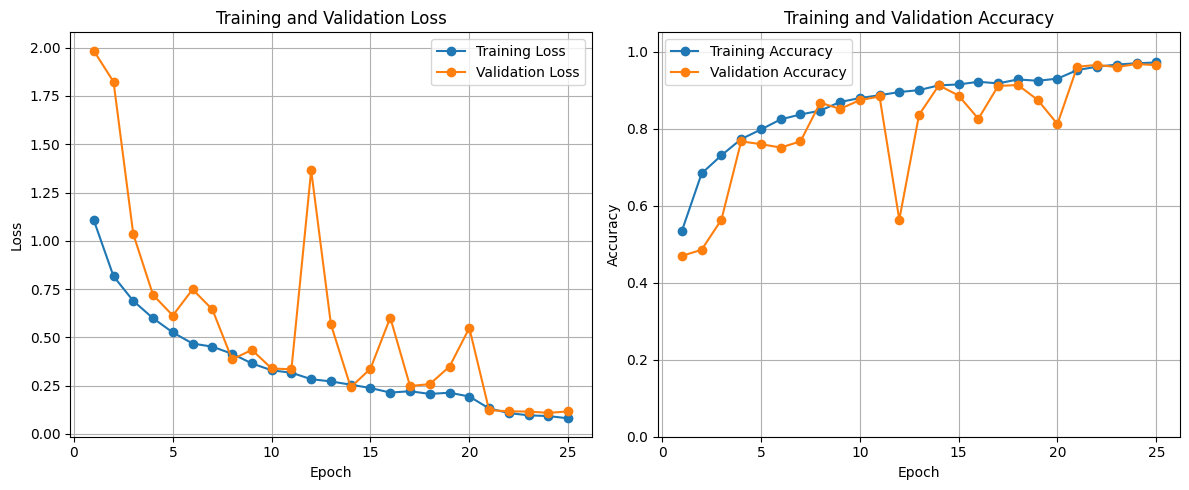

In [20]:
# %%
print("\nPlotting training and validation history...")

try:
    epochs_range = range(1, NUM_EPOCHS + 1) # Ensure x-axis matches epochs run

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    if history['train_loss'] and history['val_loss']: # Check if history has data
        plt.plot(epochs_range, history['train_loss'], marker='o', linestyle='-', label='Training Loss')
        plt.plot(epochs_range, history['val_loss'], marker='o', linestyle='-', label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid(True)
    else:
        plt.text(0.5, 0.5, 'No loss data to plot.', ha='center', va='center')


    # Plot Accuracy
    plt.subplot(1, 2, 2)
    if history['train_acc'] and history['val_acc']: # Check if history has data
        plt.plot(epochs_range, history['train_acc'], marker='o', linestyle='-', label='Training Accuracy')
        plt.plot(epochs_range, history['val_acc'], marker='o', linestyle='-', label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()
        plt.grid(True)
        plt.ylim(0, 1.05) # Set y-axis limit for accuracy (0 to 1)
    else:
        plt.text(0.5, 0.5, 'No accuracy data to plot.', ha='center', va='center')


    plt.tight_layout()
    plt.show()
except Exception as e:
     print(f"Could not plot history: {e}")